In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamtapendu/chest-x-ray-lungs-segmentation")

print("Path to dataset files:", path)

100%|██████████| 3.59G/3.59G [00:49<00:00, 78.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamtapendu/chest-x-ray-lungs-segmentation/versions/1


In [ ]:
import os
os.listdir(path+"/Chest-X-Ray/Chest-X-Ray/image/")

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [11]:
IMAGE_DIR = path+'/Chest-X-Ray/Chest-X-Ray/image'
MASK_DIR = path+'/Chest-X-Ray/Chest-X-Ray/mask'
IMG_SIZE = 256

def load_data(image_dir, mask_dir, img_size):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)

        image = load_img(img_path, target_size=(img_size, img_size), color_mode='grayscale')
        mask = load_img(mask_path, target_size=(img_size, img_size), color_mode='grayscale')

        image = img_to_array(image) / 255.0
        mask = img_to_array(mask) / 255.0
        mask = np.where(mask > 0.5, 1, 0)  # Binarize mask

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, Y = load_data(IMAGE_DIR, MASK_DIR, IMG_SIZE)
print(X.shape, Y.shape)


(704, 256, 256, 1) (704, 256, 256, 1)


In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [13]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    b = layers.Conv2D(256, 3, activation='relu', padding='same')(b)

    # Decoder
    u2 = layers.UpSampling2D()(b)
    u2 = layers.Concatenate()([u2, c2])
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c1])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model

unet = build_unet((IMG_SIZE, IMG_SIZE, 1))
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = unet.fit(X_train, Y_train,
                   validation_data=(X_val, Y_val),
                   batch_size=8,
                   epochs=20)

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 83s 767ms/step - accuracy: 0.7475 - loss: 0.5473 - val_accuracy: 0.7838 - val_loss: 0.3610
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.8563 - loss: 0.3309 - val_accuracy: 0.9228 - val_loss: 0.2049
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 295ms/step - accuracy: 0.9183 - loss: 0.2077 - val_accuracy: 0.9360 - val_loss: 0.1719
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 288ms/step - accuracy: 0.9320 - loss: 0.1799 - val_accuracy: 0.9300 - val_loss: 0.1814
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 280ms/step - accuracy: 0.9411 - loss: 0.1576 - val_accuracy: 0.9540 - val_loss: 0.1301
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.9570 - loss: 0.1167 - val_accuracy: 0.9624 - val_loss: 0.1119
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 272ms/step - accuracy: 0.9607 - loss: 0.1078 - val_accuracy: 0.9686 - val_loss: 0.0882
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 297ms/step - accuracy: 0.9687 - loss: 0.0872 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


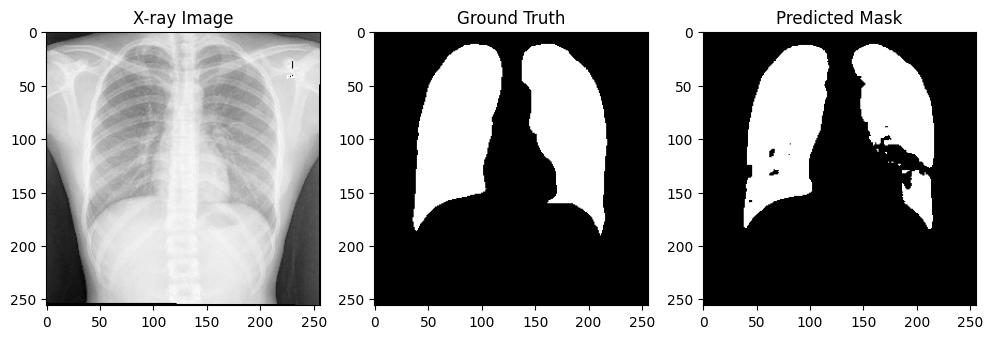

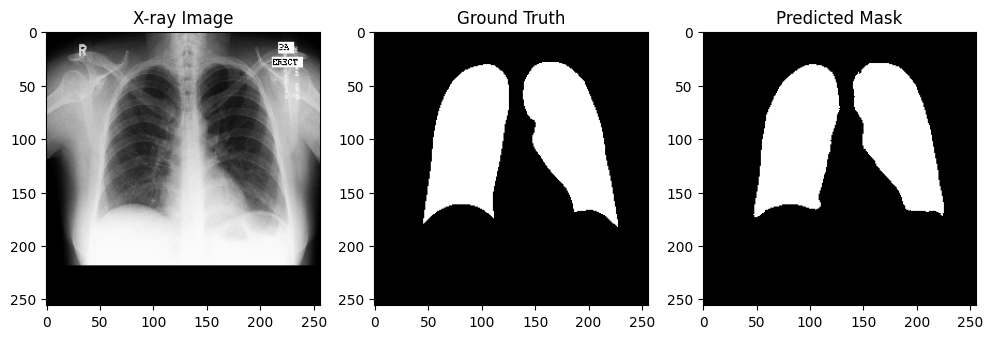

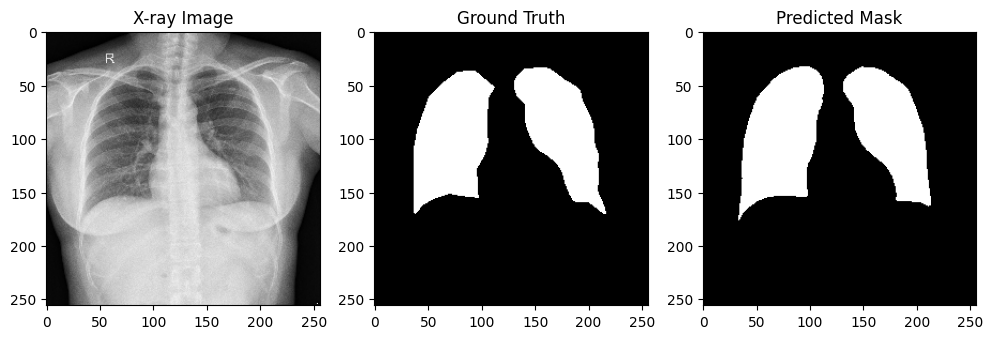

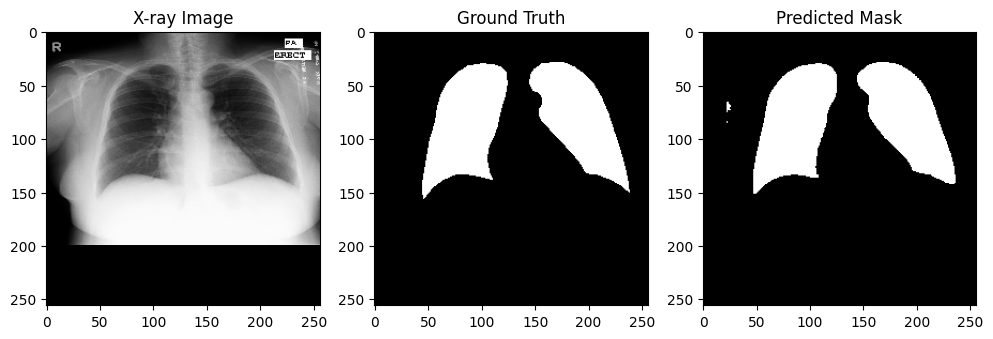

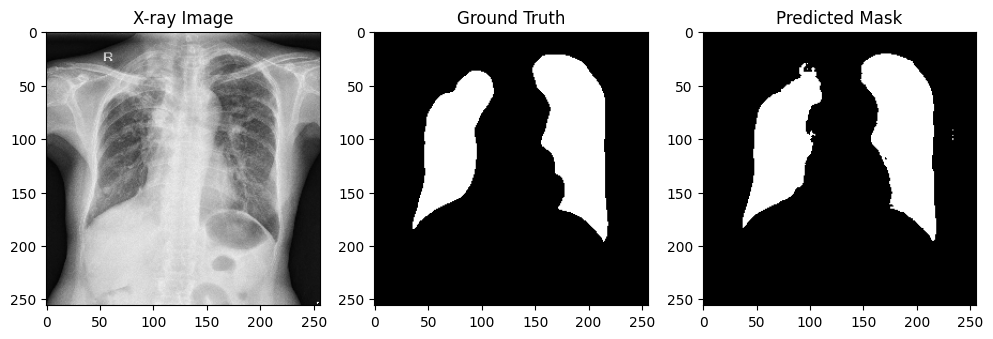

In [15]:
preds = unet.predict(X_val[:5])

for i in range(5):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title("X-ray Image")

    plt.subplot(1,3,2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.show()


In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def show_overlay(image, mask, alpha=0.4):
    """
    Show mask overlay on top of the grayscale image.

    image: Original X-ray image (grayscale, shape HxWx1 or HxW)
    mask:  Predicted binary mask (same size as image)
    alpha: Transparency factor
    """
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[-1] == 1:
        image = cv2.cvtColor(image.squeeze(), cv2.COLOR_GRAY2RGB)

    # Ensure mask is binary and resize if needed
    mask = (mask > 0.5).astype(np.uint8)
    mask_colored = np.zeros_like(image)
    mask_colored[:, :, 1] = mask.squeeze() * 255  # Green mask

    # Blend original image with mask
    overlayed = cv2.addWeighted(image, 1, mask_colored, alpha, 0)

    # Plot the result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlayed)
    plt.axis('off')
    plt.title("Predicted Mask Overlay")
    plt.show()


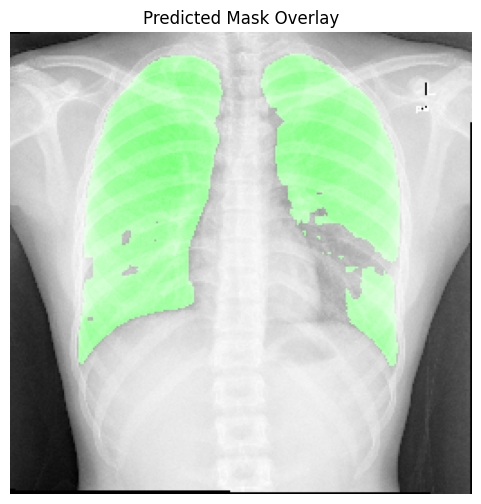

In [17]:
# Example:
i = 0
show_overlay(X_val[i], preds[i])


In [18]:
unet.save("model.keras")